# 4.2 Кубический свободный сплайн

***Задание:***
Написать программу для построения свободного кубического сплайна (2-е производные на концах равны 0) по табличным данным.

# Теория

***Кубический сплайн*** — гладкая функция, область определения которой разбита на конечное число отрезков, на каждом из которых она совпадает с некоторым кубическим многочленом (полиномом).

- Рассмотрим $S(x)$ на $k$-ом отрезке $[x_{k-1}, x_{k}], t \in [0,1]$

$$u_k = S''(x_k), h_k = x_k - x_{k-1}, x = x_{k-1} + th_k$$

- $S$ - кубический многочлен при $x \in [x_{k-1}, x_{k}]$, находим:

$$S''(x) = (1-t)u_{k-1} + tu_k$$

$$S'(x) = S'(x_{k-1}) + h_k \left(\frac{1}{2} - \frac{(1-t)^2}{2}\right)u_{k-1} + h_k\frac{t^2}{2}u_k$$

$$S(x) = S(x_{k-1}) + h_ktS'(x_{k-1})+h^2_k\left(\frac{t}{2} + \frac{(1-t)^3}{6} - \frac{1}{6}\right)u_{k-1} + h^2_k\frac{t^3}{6}u_k$$

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

In [32]:
# Функция, которая создает кубический естественный сплайн и считает значение в заданной точке.
def spline(x, y, n, x_):
    '''x : массив независимых переменных.
       y : массив значений.
       n : размер массивов, по которому строится сплайн.
       x_: точки, в которых вычисляется сплайн.
    '''
    
    # коэффициенты полиномов не выше 3
    coef = np.zeros((4, n))
    
    # прогоночные коэффициенты
    a = np.zeros(n-1)
    b = np.zeros(n-1)
    
    # прямым ход
    last_c1 = 0 # вспомогательный коэффициент
    last_c2 = 0 # вспомогательный коэффициент
    for k in np.arange(1, n-1):
        h_k = x[k] - x[k-1]
        a[k] = -1*(x[k+1] - x[k])/(h_k * a[k-1] + 2*(h_k + x[k+1] - x[k]))
        b[k] = (6*((y[k+1] - y[k]) / (x[k+1] - x[k]) - (y[k] - y[k-1]) / h_k) - h_k*b[k-1]) / (h_k*a[k-1] + 2*(h_k + x[k+1] - x[k]))
        last_c1 = 6*((y[k+1] - y[k]) / (x[k+1] - x[k]) - (y[k] - y[k-1]) / h_k)
        last_c2 = 2*(h_k + x[k + 1] - x[k])

    # обратный ход (для квадратов)
    coef[1, n-1] = (last_c1 - (x[n-2] - x[n-3])*b[n-2])/(last_c2 +(x[n-2] - x[n-3])*a[n-2])
    for k in np.arange(n-2,0,-1):
        coef[1,k] = a[k]*coef[1,k+1] + b[k]
    
    # для высших степеней
    for k in np.arange(n-1, 0, -1):
        h_k = x[k] - x[k - 1]
        coef[0, k] = (coef[1, k] - coef[1, k-1]) / h_k
        coef[2, k] = h_k*(2*coef[1, k] + coef[1, k-1]) / 6+(y[k] - y[k-1]) / h_k
        coef[3, k] = y[k]
    
    # теперь найдем значения в конкретных, переданных точках
    ans = np.zeros(x_.size)
    for i in np.arange(x_.size):
        k = 0
        if x_[i] <= x[0]:
            k = 1
        elif x_[i] >= x[-1]:
            k = n - 1
        # бинпоик, если между
        else:
            left = 0
            right = n - 1
            while (right - left > 1):
                med = left + (right - left) // 2
                if x_[i] <= x[med]:
                    right = med
                else:
                    left = med
            k = right
        ans[i] = coef[3, k] + coef[2, k] * (x_[i] - x[k]) + coef[1, k] / 2 * (x_[i] - x[k])**2 + coef[0, k] / 6*(x_[i] - x[k])**3
    return ans

<Figure size 1296x720 with 0 Axes>

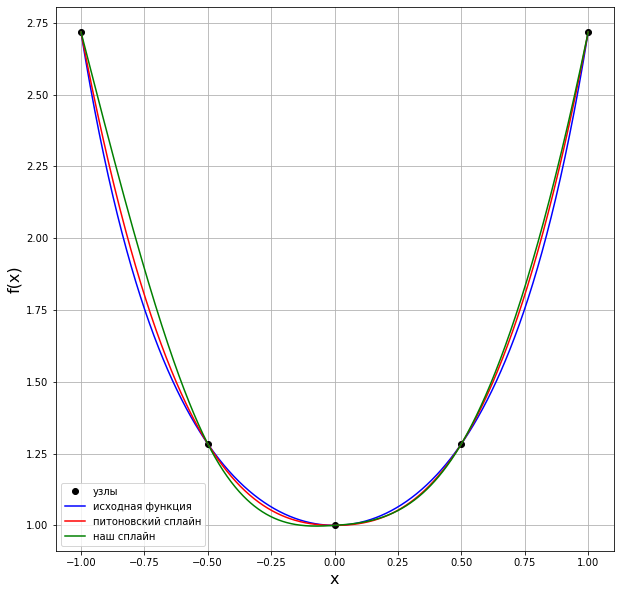

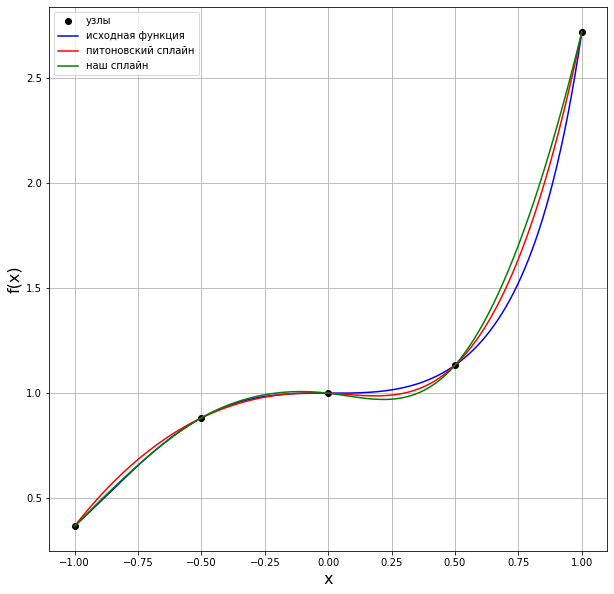

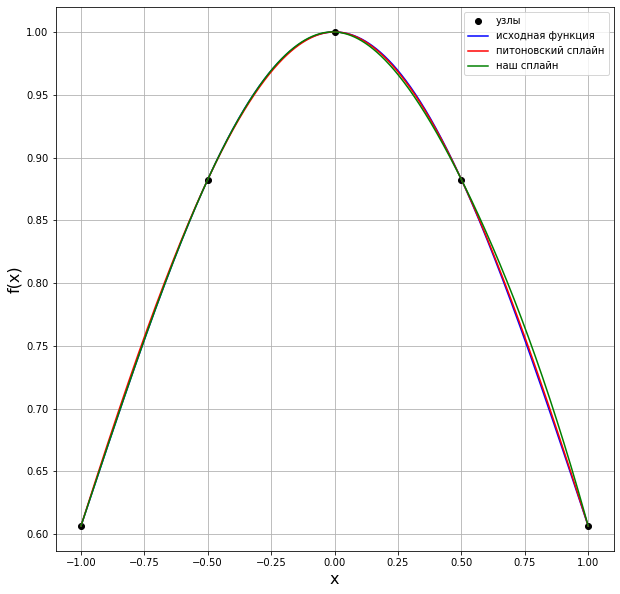

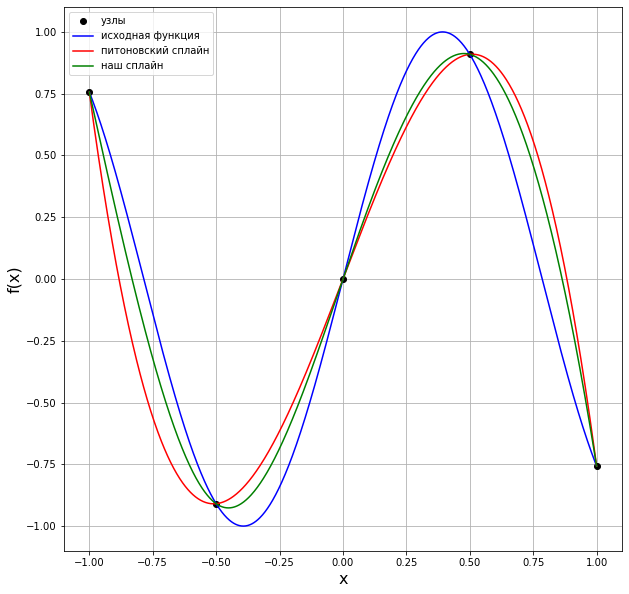

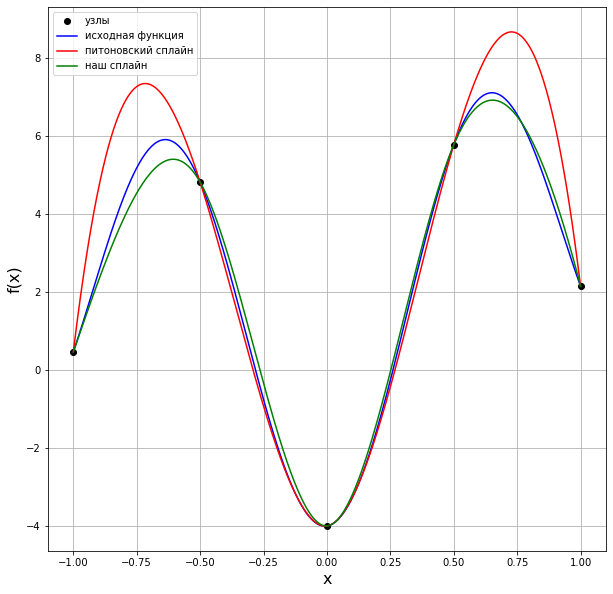

In [54]:
# равномерная сетка

f1 = lambda x: np.exp(x**2)
f2 = lambda x: np.exp(x**3)
f3 = lambda x: np.exp(-1/2*x**2)
f4 = lambda x: np.sin(4*x)
f5 = lambda x: np.sin(x) + np.exp(x**2) - 5*np.cos(5*x)
f = np.array([f1, f2, f3, f4, f5])
n = 5 # число узлов
x = np.linspace(-1, 1, n) # равномерная сетка
x_ = np.linspace(-1, 1, 1000) # подробная сетка для графиков


plt.figure(figsize=(18, 10))
for i in np.arange(5):
    plt.figure(figsize=(10, 10))
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('f(x)', fontsize=16)
    plt.plot(x, f[i](x), 'o', color='black', label='узлы')
    plt.plot(x_, f[i](x_), color='blue', label='исходная функция')
    plt.plot(x_, CubicSpline(x, f[i](x))(x_), color='red', label='питоновский сплайн')
    plt.plot(x_, build_spline(x, f[i](x), x.size, x_), color='green', label='наш сплайн')
    plt.legend()
    plt.show();

<Figure size 1296x720 with 0 Axes>

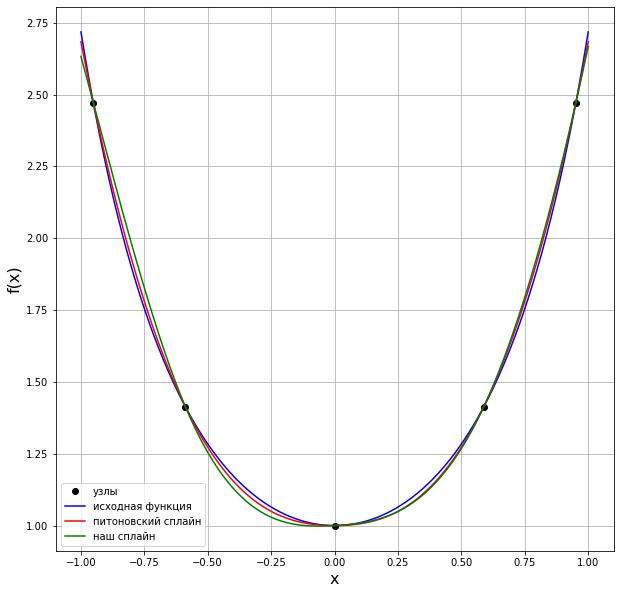

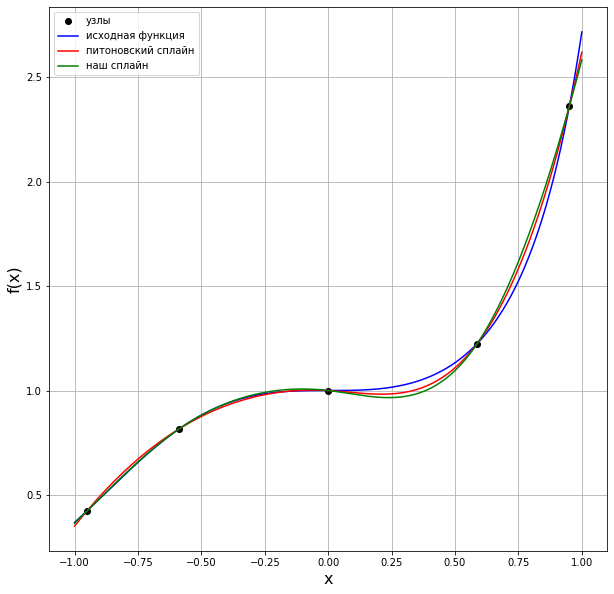

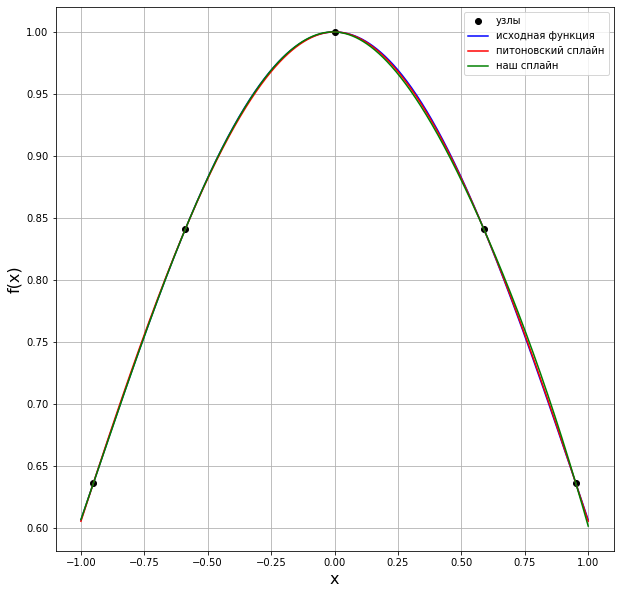

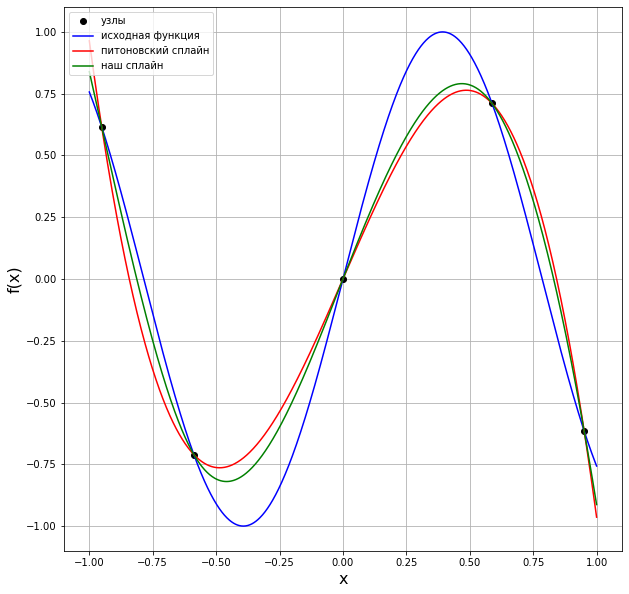

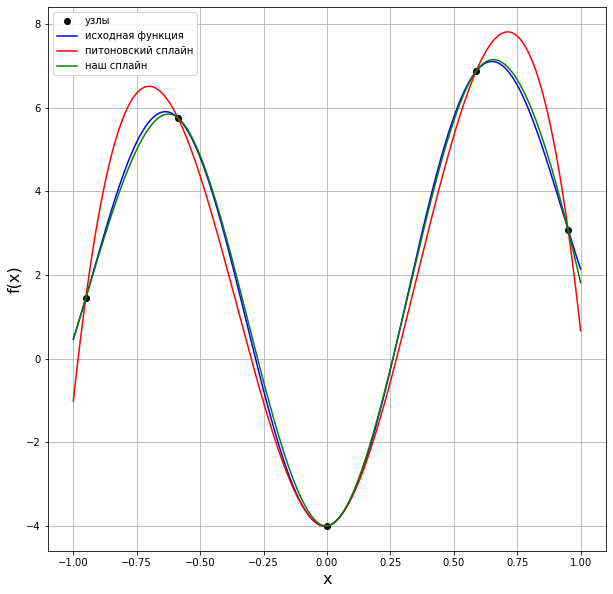

In [55]:
# неравномерная сетка, нули многочленов Чебышёва

n = 5 # число узлов
x = np.sort(np.cos(np.pi*(2*np.arange(1, n+1)-1)/(2*n))) 

plt.figure(figsize=(18, 10))
for i in np.arange(5):
    plt.figure(figsize=(10, 10))
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('f(x)', fontsize=16)
    plt.plot(x, f[i](x), 'o', color='black', label='узлы')
    plt.plot(x_, f[i](x_), color='blue', label='исходная функция')
    plt.plot(x_, CubicSpline(x, f[i](x))(x_), color='red', label='питоновский сплайн')
    plt.plot(x_, build_spline(x, f[i](x), x.size, x_), color='green', label='наш сплайн')
    plt.legend()
    plt.show();

# Вывод: 
***как видно из полученных иллюстрации, при больших ``n`` интерполянта визуально ничем не отличается от исходной функции, а при маленьких ``n`` неплохо приближается и в случае равномерной сетки и в случае неравномерной сетки.***

***Ссылки.***
- [code](https://www.cyberforum.ru/python-beginners/thread2447664.html)
- [theory](http://www.machinelearning.ru/wiki/index.php?title=Интерполяция_кубическими_сплайнами)
- [code](http://pers.narod.ru/algorithms/pas_ispline.html)
